### Imports

In [1]:
# Standard Python modules
import os, sys
import yaml
import glob
from pathlib import Path
import numpy as np
import pandas as pd
import xarray as xr
# matplotlib
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from mpl_toolkits.axes_grid1 import AxesGrid
from matplotlib import rcParams
from matplotlib.colors import ListedColormap
# plot styles/formatting
import seaborn as sns
import cmocean.cm as cmo
import cmocean
# cartopy
import cartopy.crs as ccrs
from cartopy.mpl.geoaxes import GeoAxes

# Extra 
from scipy.ndimage import gaussian_filter    # smoothing contour lines
from IPython.display import Image, display

# import personal modules

# Path to modules
sys.path.append('../modules')

# Import my modules
from plotter import draw_basemap, make_cmap
import nclcmaps as nclc
from timeseries import select_months, select_months_ds, combine_ar_ds_df
from utils import check_mkdir, load_era5_ds

In [2]:
import dask
dask.config.set(**{'array.slicing.split_large_chunks': False})

In [3]:
# Set up paths
server = 'great'
if server == 'great':
    path_to_data = '/home/nash/DATA/data/'
elif server == 'frontera':
    path_to_data = '/work2/08540/dlnash/frontera/data/'                                      # project data -- read only

path_to_out  = '../out/'       # output files (numerical results, intermediate datafiles) -- read & write
path_to_figs = '../figs/'      # figures


In [4]:
start_date = '1979-12-01'
end_date = '2015-02-28'
mon_s = 12
mon_e = 2

lonmin = 60.
lonmax = 115.
latmin = 15.
latmax = 55.

## load ar data

In [5]:
filepath = path_to_out + 'AR-types_ALLDAYS.csv'
df = pd.read_csv(filepath)

# set times as index
df = df.rename(columns={'Unnamed: 0': 'date'})
df = df.set_index(pd.to_datetime(df['date']))

# select only djf months
idx = (df.index.month >= mon_s) | (df.index.month <= mon_e)
df = df.loc[idx]

# normalize datetimes to 00 UTC
df.index = df.index.strftime("%Y-%m-%d")

# set to days available in WRF
idx = (df.index >= start_date) & (df.index <= end_date)
df = df.loc[idx]

# # select only ar days
idx = (df['AR_CAT'] > 0)
df = df.loc[idx]

# get list of dates that ar is present
ar_dates = pd.to_datetime(df.index).values
df

,date,AR_CAT
date,,
1979-12-01,1979-12-01 09:00:00,2
1979-12-02,1979-12-02 09:00:00,1
1979-12-08,1979-12-08 09:00:00,2
1979-12-09,1979-12-09 09:00:00,1
1979-12-16,1979-12-16 09:00:00,1
...,...,...
2015-02-23,2015-02-23 09:00:00,1
2015-02-24,2015-02-24 09:00:00,3
2015-02-25,2015-02-25 09:00:00,3


### Load ERA5 IVT and 250Z data

In [6]:
## simple load era5 data
bounds = [lonmin, lonmax, latmin, latmax]

# select vars and levs
varlst = ['ivt', 'huvq', 'prec']
levlst = [None, 250., None]

f = []

for i, (pathvar, lev) in enumerate(zip(varlst, levlst)):
    print('loading ...', pathvar)
    s = load_era5_ds(path_to_data=path_to_data, pathvar=pathvar, bbox=bounds, anom=False, lev=lev)
    ds = s.load_ds()
    # subset to just ar days
    ds = ds.sel(time = ar_dates)
    
    # Combine AR Cat and freeze data w/ WRF data
    colnames = ['AR_CAT']
    for i, col in enumerate(colnames):
        ds[col] = ('time', df[col])
        ds = ds.set_coords(col)
        
    if pathvar == 'ivt':
        ds = ds.assign(ivt=lambda ds: np.sqrt(ds.ivte**2 + ds.ivtn**2))
    elif pathvar == 'huvq':
        # convert geopotential to geopotential height (m)
        ds = ds.assign(H=lambda ds: ds['H']/(9.80665))
    elif pathvar == 'prec':
        # convert prec units to mm/day
        ds = ds.assign(prec=lambda ds: ds['prec']*86400)
        
    print('ds size in GB {:0.2f}\n'.format(ds.nbytes / 1e9))
    f.append(ds)
    


loading ... ivt
ds size in GB 0.13

loading ... huvq
ds size in GB 0.18

loading ... prec
ds size in GB 0.36



### Load WRF daily precip, geopotential, and ivt data

In [7]:
fname = '/home/nash/DATA/data/wrf_hasia/d01/geopotential/daily/out.wrf6km.geopotential.daily_*.nc'
ds2 = xr.open_mfdataset(fname)
ds2 = select_months_ds(ds2, mon_s, mon_e)
ds2_time = ds2.time.values
ds2

,Array,Chunk
Bytes,3.35 GB,93.90 MB
Shape,"(3249, 4, 249, 259)","(91, 4, 249, 259)"
Count,148 Tasks,37 Chunks
Type,float32,numpy.ndarray


In [8]:
%%time
start_yr = 1979
end_yr = 2015
domains = ['d01', 'd01', 'd02']
varname_lst = ['ivt', 'geopotential', 'prec']

## loop through each ds
ds_lst = []
for i, (dom, varname) in enumerate(zip(domains, varname_lst)):
    
    if server == 'great':
        data_path = path_to_data + 'wrf_hasia/'
        filename_pattern = '{0}/{1}/daily/out.wrf6km.{1}.daily_*.nc'.format(dom, varname)
    else:
        data_path = path_to_data + 'wrf_preprocessed_data/wrf_6km/'
        filename_pattern = '{0}/{1}/3hr/tmp_*.nc'.format(dom, varname)
    
    fname = data_path + filename_pattern
    print(fname)

    ds = xr.open_mfdataset(fname)
    
    # subset to DJF
    ds = select_months_ds(ds, mon_s, mon_e)
    
    if varname == 'prec':
        ds['time'] = ds2_time
    
    # subset to just ar days
    ds = ds.sel(time = ar_dates)
    
    if varname == 'ivt':
        ds = ds.assign(ivt=lambda ds: np.sqrt(ds.ivtu**2 + ds.ivtv**2))
    if varname == 'geopotential':
        ds = ds.sel(lev=250.)
    
    # Combine AR Cat and freeze data w/ WRF data
    colnames = ['AR_CAT']
    for i, col in enumerate(colnames):
        ds[col] = ('time', df[col])
        ds = ds.set_coords(col)
    
    ds_lst.append(ds)
    
ds_lst[0]

/home/nash/DATA/data/wrf_hasia/d01/ivt/daily/out.wrf6km.ivt.daily_*.nc
/home/nash/DATA/data/wrf_hasia/d01/geopotential/daily/out.wrf6km.geopotential.daily_*.nc
/home/nash/DATA/data/wrf_hasia/d02/prec/daily/out.wrf6km.prec.daily_*.nc
CPU times: user 1.87 s, sys: 189 ms, total: 2.06 s
Wall time: 2.15 s


<xarray.Dataset>
Dimensions:  (time: 1250, lat: 249, lon: 259)
Coordinates:
  * time     (time) datetime64[ns] 1979-12-01 1979-12-02 ... 2015-02-27
  * lat      (lat) float32 16.43 16.63 16.83 17.02 ... 55.8 55.92 56.04 56.15
  * lon      (lon) float32 60.2 60.41 60.62 60.83 ... 113.2 113.4 113.6 113.8
    AR_CAT   (time) int64 2 1 2 1 1 3 1 1 1 3 2 1 1 ... 2 2 2 2 2 2 1 1 3 3 3 3
Data variables:
    ivtu     (time, lat, lon) float64 dask.array<chunksize=(13, 249, 259), meta=np.ndarray>
    ivtv     (time, lat, lon) float64 dask.array<chunksize=(13, 249, 259), meta=np.ndarray>
    iwv      (time, lat, lon) float64 dask.array<chunksize=(13, 249, 259), meta=np.ndarray>
    ivt      (time, lat, lon) float64 dask.array<chunksize=(13, 249, 259), meta=np.ndarray>

In [9]:
ds_lst[1]

<xarray.Dataset>
Dimensions:  (time: 1250, lat: 249, lon: 259)
Coordinates:
  * time     (time) datetime64[ns] 1979-12-01 1979-12-02 ... 2015-02-27
    lev      int64 250
  * lat      (lat) float32 16.43 16.63 16.83 17.02 ... 55.8 55.92 56.04 56.15
  * lon      (lon) float32 60.2 60.41 60.62 60.83 ... 113.2 113.4 113.6 113.8
    AR_CAT   (time) int64 2 1 2 1 1 3 1 1 1 3 2 1 1 ... 2 2 2 2 2 2 1 1 3 3 3 3
Data variables:
    z        (time, lat, lon) float32 dask.array<chunksize=(13, 249, 259), meta=np.ndarray>

### Compute AR Composites

In [10]:
%%time
# ds_lst = wrf_ivt, wrf_250z, wrf_prec, era5_ivt, era5_huvq, era5_prec
ds_lst = ds_lst + f
ds_comp_lst = []
for i, ds in enumerate(ds_lst):
    ds_ar_comp = ds.groupby('AR_CAT').mean('time').compute()
    ds_comp_lst.append(ds_ar_comp)
ds_comp_lst

CPU times: user 3min 47s, sys: 7min 1s, total: 10min 48s
Wall time: 13min


[<xarray.Dataset>
 Dimensions:  (AR_CAT: 3, lat: 249, lon: 259)
 Coordinates:
   * lat      (lat) float32 16.43 16.63 16.83 17.02 ... 55.8 55.92 56.04 56.15
   * lon      (lon) float32 60.2 60.41 60.62 60.83 ... 113.2 113.4 113.6 113.8
   * AR_CAT   (AR_CAT) int64 1 2 3
 Data variables:
     ivtu     (AR_CAT, lat, lon) float64 -29.86 -30.19 -30.52 ... 8.809 8.935
     ivtv     (AR_CAT, lat, lon) float64 -17.25 -16.54 -16.16 ... -7.742 -7.672
     iwv      (AR_CAT, lat, lon) float64 19.7 19.62 19.54 ... 1.503 1.513 1.595
     ivt      (AR_CAT, lat, lon) float64 74.61 73.85 73.16 ... 15.19 14.89 14.98,
 <xarray.Dataset>
 Dimensions:  (AR_CAT: 3, lat: 249, lon: 259)
 Coordinates:
     lev      int64 250
   * lat      (lat) float32 16.43 16.63 16.83 17.02 ... 55.8 55.92 56.04 56.15
   * lon      (lon) float32 60.2 60.41 60.62 60.83 ... 113.2 113.4 113.6 113.8
   * AR_CAT   (AR_CAT) int64 1 2 3
 Data variables:
     z        (AR_CAT, lat, lon) float32 1.09e+04 1.09e+04 ... 9.694e+03,
 <xarr

### Evaluate Bias

In [11]:
def evaluate_spatial_bias(model, obs):
    ## regrid/interpolate data to all have same grid size
    regrid_lats = obs.lat
    regrid_lons = obs.lon

    model = model.interp(lon=regrid_lons, lat=regrid_lats)

    # model - observation = bias
    bias = model - obs
    return bias

In [13]:
## evaluate bias of wrf compared to ERA5
ivt_bias = evaluate_spatial_bias(ds_comp_lst[0].ivt, ds_comp_lst[3].ivt)
upper_bias = evaluate_spatial_bias(ds_comp_lst[1].z, ds_comp_lst[4].H)
prec_bias = evaluate_spatial_bias(ds_comp_lst[2].prec, ds_comp_lst[5].prec)

### Plot Bias

In [17]:
# import configuration file for dictionary choice
yaml_doc = '../data/plt_config.yml'

config = yaml.load(open(yaml_doc), Loader=yaml.SafeLoader)
#select dictionaries - choose var, anom/nanom, and season
# upper_ precip_ ivt_ and non_anom anom
plot_dict_upper = config['upper_non_anom']
plot_dict_ivt = config['ivt_non_anom']
plot_dict_prec = config['precip_non_anom']

plot_dicts = [plot_dict_upper, plot_dict_ivt, plot_dict_prec]

In [32]:
# Set seaborn plot style
sns.set()
sns.set_style("ticks", {'patch.force_edgecolor':False})

# Set projections
datacrs = ccrs.PlateCarree()   # data/source
mapcrs = ccrs.PlateCarree()    # map/destination

# Set tick/grid locations
dy = np.arange(20,60,10)
dx = np.arange(70,110,10)

dy2 = np.arange(25,45,5)
dx2 = np.arange(70,100,10)


# 9-panel plot    
fig_dict = {'nrows': 3,
            'ncols': 3,
            'artype_lst': list(range(1, 3+1)),
            'panel': '9pan'}

# hack for tick labels
share_bottom = [False, False, True]
# column 1 lats
share_right1 = [False, False, False]
share_left1 = [False, False, False]
# column 2 lats
share_right2 = [False, False, False]
share_left2 = [True, True, True]
# column 3 lats
share_right3= [True, True, True]
share_left3 = [False, False, False]

wrf_ivt = ds_comp_lst[0]
wrf_250z = ds_comp_lst[1]
wrf_prec = ds_comp_lst[2]
era5_ivt = ds_comp_lst[3]
era5_huvq = ds_comp_lst[4]
era5_prec = ds_comp_lst[5]

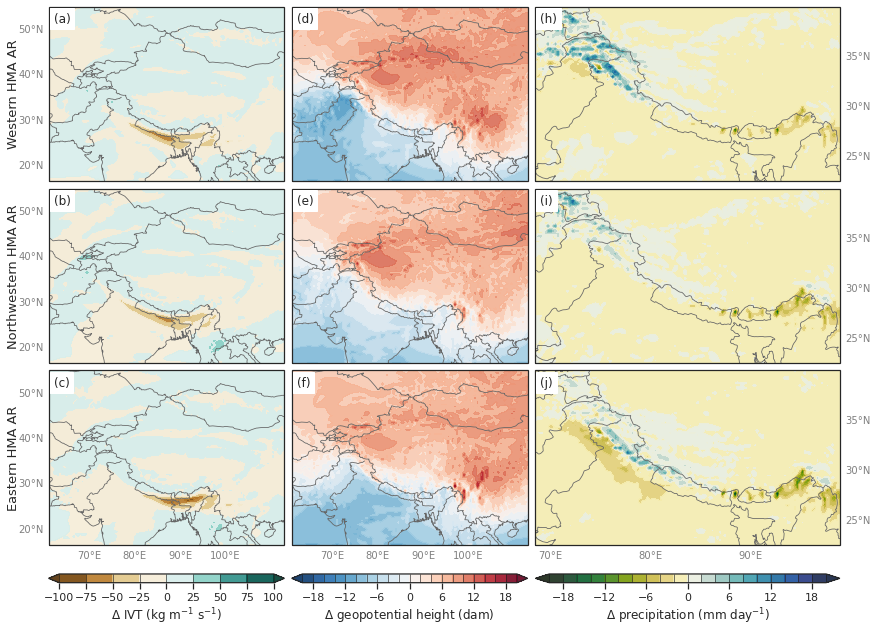

In [34]:
filepath = path_to_figs + 'composite_ar_types_bias' + '.png'
nrows = 3
ncols = 2
artype_lst =  list(range(1, 3+1))
row_lbl = ['Western HMA AR', 'Northwestern HMA AR', 'Eastern HMA AR']
col_lbl1 = ['(a)', '(b)', '(c)']
col_lbl2 = ['(d)', '(e)', '(f)']
col_lbl3 = ['(h)', '(i)', '(j)']
# lonmin, lonmax, latmin, latmax
ext1 = [61, 113, 16.5, 55]
ext2 = [68.5, 99, 22.5, 40]

# Create figure
fig = plt.figure(figsize=(15,10))

# Set up Axes Grid
axes_class = (GeoAxes,dict(map_projection=mapcrs))
axgr = AxesGrid(fig, [0.1, 0.1, 0.66, 0.8], axes_class=axes_class,
                nrows_ncols=(nrows, ncols), axes_pad = 0.1,
                cbar_location='bottom', cbar_mode='edge',
                cbar_pad=0.4, cbar_size='5%',label_mode='',
                direction='column',
                aspect=True,
                share_all = False)

axgr2 = AxesGrid(fig, [0.635, 0.1, 0.33, 0.8], axes_class=axes_class,
                nrows_ncols=(nrows, 1), axes_pad = 0.1,
                cbar_location='bottom', cbar_mode='edge',
                cbar_pad=0.4, cbar_size='5%',label_mode='',
                direction='column',
                aspect=True,
                share_all = False)
xpt = 5
ypt = 159
################################
########## IVT PLOTS ###########
################################
for k, (ax, ar_type) in enumerate(zip(axgr[0:nrows], artype_lst)):  
    ax = draw_basemap(ax, extent=ext1, xticks=dx, yticks=dy,
                      left_lats=share_left2[k], right_lats=share_right2[k], bottom_lons=share_bottom[k])
    
    # Contour Filled - IVT bias (filled contour)
    data = ivt_bias.sel(AR_CAT=ar_type)
    cflevs = np.arange(-100, 125, 25)
    cf = ax.contourf(data.lon.values, data.lat.values, data.values, transform=datacrs,
                     levels=cflevs, cmap='BrBG', alpha=0.9, extend='both')

    
    # subtitles
#     ax.set_title(col_lbl1[k], loc='left',fontsize=13)
    ax.annotate(col_lbl1[k], (xpt, ypt), xycoords='axes points', fontsize=12.,
                    backgroundcolor='white')
    # Row labels
    ax.text(-0.12, 0.5, row_lbl[k], va='bottom', ha='center',
        rotation='vertical', rotation_mode='anchor', fontsize=13,
        transform=ax.transAxes)

# Colorbar (single)
cb = fig.colorbar(cf, axgr.cbar_axes[0], orientation='horizontal', drawedges=True)
cb.set_label(r'$\Delta$ IVT (kg m$^{-1}$ s$^{-1}$)')
    
#################################
########## UPPER PLOTS ##########
#################################
for k, (ax, ar_type) in enumerate(zip(axgr[nrows:nrows+nrows], artype_lst)):
    ax = draw_basemap(ax, extent=ext1, xticks=dx, yticks=dy,
                      left_lats=share_left1[k], right_lats=share_right1[k], bottom_lons=share_bottom[k])
    
    # Contour Filled - 250-hPa Heights Bias
    data = upper_bias.sel(AR_CAT=ar_type)
    cflevs = np.arange(-20, 22, 2)
    cf = ax.contourf(data.lon.values, data.lat.values, data.values, transform=datacrs,
                     levels=cflevs, cmap='RdBu_r', alpha=0.9, extend='both')
        
    ax.annotate(col_lbl2[k], (xpt, ypt), xycoords='axes points', fontsize=12.,
                    backgroundcolor='white')

# Colorbar (single edge)
cb = fig.colorbar(cf, axgr.cbar_axes[1], orientation='horizontal', drawedges=True)
cb.set_label(r'$\Delta$ geopotential height (dam)')

################################
########## PREC PLOTS ##########
################################

for k, (ax, ar_type) in enumerate(zip(axgr2, artype_lst)):   
    ax = draw_basemap(ax, extent=ext2, xticks=dx2, yticks=dy2,
                      left_lats=share_left3[k], right_lats=share_right3[k], bottom_lons=share_bottom[k])
    
    # Contour Filled - WRF precip
    data = prec_bias.sel(AR_CAT=ar_type)
    cflevs = np.arange(-20, 22, 2)
    cf = ax.contourf(data.lon.values, data.lat.values, data.values, transform=datacrs,
                     levels=cflevs, cmap=cmo.delta_r, alpha=0.9, extend='both')
       
    # subtitles
    ax.annotate(col_lbl3[k], (xpt, ypt), xycoords='axes points', fontsize=12.,
                backgroundcolor='white')
    
# # Colorbar (single)
cb = fig.colorbar(cf, axgr2.cbar_axes[0], orientation='horizontal', drawedges=True)
cb.set_label(r'$\Delta$ precipitation (mm day$^{-1}$)')
    
# Save figure
plt.savefig(filepath, dpi=300, bbox_inches='tight')

# Show
plt.show()
